In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import itertools
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt
from collections import defaultdict
import roi_config
import fixation
import hypothesis_testing
import bulk_run
import anova
import re
import utils

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [2]:
mongo = Mongo_connection()
mongo.connect()

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [62]:
utils.roi_config.encode_table

{'rpmleft': 'S', 'asi': 'S', 'alt': 'A', 'runway': 'X', 'unknown': 'Z'}

In [51]:
documents = mongo.find({})
for document in documents:
    print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))

    d_data = document["data"]
    df_data = pd.DataFrame(d_data)
    df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
    transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")
    print(transitions)

trial: 1, group: 2, pID: 001
ZXZAZASAXAXSXASAXAXSAZAZXZXSAZXZAXSXSXSXSXSXSXSXZAXSXASXSXSAXSXZXAXSXSXZXSXSXSXAXSXSXSXSXSXSXSX
trial: 1, group: 2, pID: 002
XAXAXAXAXSZXASZXSXAZAXAXAXAXSAXAXAZSXSXSXSASXZSXZXSXSXASXSXAXAXSXSXSXAXSXAXAXSAXSZXAXAXSXASXSXSXSXSAXSXSXSX
trial: 1, group: 1, pID: 003
ZAXAXAXAXSAXSXZXSXSAXAZXZXZSZSXSAXSZXSXSXASXSASXASXSZSAXSZSXAXASXAXAZXSXSXSX
trial: 1, group: 1, pID: 004
XAXSXZASXAZXZXAXAXAZASAXAXAZASAZXSXSASASXSXSXZAXZSAXZXASXSXAXSZXASXSAXSAXSAXZXAXASAXAXSXAXSAXAXASXSXSXSX
trial: 1, group: 2, pID: 005
ASZAZAZAZSZAZXZAZAXZXZAZSAZAXZAXAZSZAZAXZSZXZAXSXSXAZSXSXSXSAXSXSXSXSXZXSXSXSXZSX
trial: 1, group: 2, pID: 006
XAXAXAXAXZXAXSXAZXAXAXAZXAZAXZXZXAXASXSXSZSXSXZSXAXAZXSXSAXSXAXAXSXZXSXAXSXSXSXSXSX
trial: 1, group: 1, pID: 007
XAXSXAXZXAXAXAXZXZXAZXAXAXAXSZAXZXZSAXSXZXZAXSXSXZXASXSXZXAXZAXSXAXSXAXSXAXSXAXSX
trial: 1, group: 1, pID: 008
XASZASZXAXAXSAXSAXASAZSZSAZSXSZAZSAZAZASZXSZS
trial: 1, group: 2, pID: 009
XAZXAXAXSXSXAXZXAXAXSAXAXSXAXAZXSZXZAXAXAXSASASXASASXAXSAXA

In [53]:
pd.DataFrame(d_data)

,start,end,duration,x,y,roi
0,0.079987,1.588072,1.508085,932.412086,232.759733,runway
1,1.978104,2.497114,0.519010,840.350282,504.755308,alt
2,2.853122,3.940198,1.087076,929.794824,227.954099,runway
3,4.102186,4.410189,0.308003,836.846347,496.048145,alt
4,4.508189,5.142218,0.634029,838.663882,469.817270,alt
...,...,...,...,...,...,...
71,109.641951,110.178007,0.536056,832.197571,515.471793,alt
72,110.425988,110.698017,0.272029,964.233261,265.120773,runway
73,110.718028,122.395531,8.654336,934.149309,230.826301,runway
74,122.945553,123.325571,0.380018,842.499309,507.047486,alt


In [3]:
def frequency_of_ROI_over_time(df_data, window_length = 10):
    d = defaultdict(list)
    for i in range(int(df_data.start.values[-1])):
        start_time = i
        end_time = i + window_length
        df_x = df_data[(df_data.start >= start_time) & (df_data.start <= end_time)]
        d["A"].append(len(df_x[df_x.roi == "alt"]))
        d["S"].append(len(df_x[(df_x.roi == "asi") | (df_x.roi == "rpmleft")]))
        d["X"].append(len(df_x[df_x.roi == "runway"]))
        d["Z"].append(len(df_x[df_x.roi == "unknown"]))
    
    return d

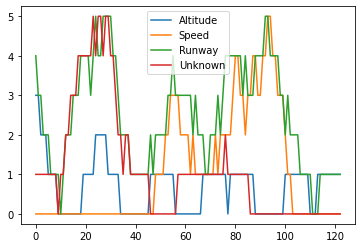

In [78]:
d_freq = frequency_of_ROI_over_time(df_data)
plt.plot(d_freq["A"], label = "Altitude")
plt.plot(d_freq["S"], label = "Speed")
plt.plot(d_freq["X"], label = "Runway")
plt.plot(d_freq["Z"], label = "Unknown")
plt.legend()

In [49]:
df_data.iloc[30:70]

,start,end,duration,x,y,roi
30,55.048477,55.404524,0.356047,846.879694,521.692394,alt
31,55.600502,56.623550,1.023048,955.571450,197.971665,runway
32,57.091571,57.337582,0.246011,659.188239,457.131588,asi
33,57.709617,61.123755,3.104136,960.942346,174.989771,runway
34,61.587792,62.137857,0.550065,677.857132,453.795808,asi
35,62.543817,63.323870,0.780053,955.077607,182.463939,runway
36,63.647870,64.169909,0.522039,660.495176,457.806283,asi
37,64.555908,66.117980,1.562072,944.836903,197.976463,runway
38,66.574002,66.940018,0.366016,841.637965,573.627460,unknown
39,67.184028,72.636286,4.998239,935.116286,192.562535,runway


In [5]:
transitions

'XZAZAXSZXAXSZXZAXAZXAXZXAZXZXZXAZSXSXSXAXZAXZASZAZXZAZSZAXZAXSXAXAXZXAXSXAXZXZAXSZAZXZASXSAXAXAXSXZXSX'

In [4]:
def find_pos(ch, s):
    return [m.start() for m in re.finditer(ch, s)]

def create_first_order_transition_matrix(sequence):
    d = {}
    for c in sequence:
        if c in list(d.keys()):
            continue
        d_char = defaultdict(int)
        list_char_pos = find_pos(c, sequence)
        for pos in list_char_pos:
            if pos == len(sequence) - 1: # reach the end of the string
                continue
            next_char = sequence[pos + 1]
            d_char[next_char] += 1
        d[c] = d_char

    df_count = pd.DataFrame(d).reindex(columns=["A", "S", "X", "Z"]).sort_index().fillna(0)
    df_prob = df_count/df_count.sum(axis = 0)
    
    return df_count, df_prob

In [7]:
create_first_order_transition_matrix(transitions)

(      A    S     X     Z
 A   0.0  1.0  12.0  12.0
 S   2.0  0.0  10.0   2.0
 X  16.0  8.0   0.0  12.0
 Z   7.0  5.0  14.0   0.0,
       A         S         X         Z
 A  0.00  0.071429  0.333333  0.461538
 S  0.08  0.000000  0.277778  0.076923
 X  0.64  0.571429  0.000000  0.461538
 Z  0.28  0.357143  0.388889  0.000000)

In [5]:
def create_empty_matrix():
    permutations = list(itertools.product("ASXZ", repeat=3))
    good_permutations = []
    for c in permutations:
        if c[0] == c[1] or c[1] == c[2]:
            continue
        good_permutations.append(c)
        
    d = defaultdict(dict)
    for perm in good_permutations:
        first_2gram_transition = perm[0] + perm[1]
        d[first_2gram_transition][perm[2]] = 0
        
    return d

In [6]:
def create_second_order_transition_matrix(sequence):
    d = create_empty_matrix()
    processed_first_2gram_transitions = []
    for i in range(len(sequence) - 1):
        first_2gram_transition = sequence[i:i+2]
        if first_2gram_transition in processed_first_2gram_transitions: # if the 2gram is already processed, then next
            continue
        
        list_pos = find_pos(first_2gram_transition, sequence)
        for pos in list_pos:
            if pos == len(sequence) - 2: # reach the end of the string
                continue
            d[first_2gram_transition][sequence[pos + 2]] += 1
            
        processed_first_2gram_transitions.append(first_2gram_transition)
            
    df_count = (pd.DataFrame(d).sort_index())
    df_prob = (df_count/df_count.sum(axis = 0)).fillna(0)
    
    return df_count, df_prob

In [10]:
create_second_order_transition_matrix(transitions)

(    AS   AX   AZ   SA   SX   SZ   XA   XS   XZ   ZA   ZS   ZX
 A  0.0  4.0  1.0  NaN  3.0  3.0  NaN  1.0  8.0  NaN  0.0  5.0
 S  NaN  6.0  2.0  0.0  3.0  0.0  0.0  NaN  0.0  2.0  NaN  1.0
 X  1.0  NaN  4.0  1.0  NaN  2.0  9.0  6.0  6.0  6.0  1.0  NaN
 Z  1.0  6.0  NaN  0.0  1.0  NaN  3.0  3.0  NaN  4.0  1.0  6.0,
     AS     AX        AZ   SA        SX   SZ    XA   XS        XZ        ZA  \
 A  0.0  0.250  0.142857  0.0  0.428571  0.6  0.00  0.1  0.571429  0.000000   
 S  0.0  0.375  0.285714  0.0  0.428571  0.0  0.00  0.0  0.000000  0.166667   
 X  0.5  0.000  0.571429  1.0  0.000000  0.4  0.75  0.6  0.428571  0.500000   
 Z  0.5  0.375  0.000000  0.0  0.142857  0.0  0.25  0.3  0.000000  0.333333   
 
     ZS        ZX  
 A  0.0  0.416667  
 S  0.0  0.083333  
 X  0.5  0.000000  
 Z  0.5  0.500000  )

In [150]:
df_prob.fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.6,0.0,0.0,0.153846,0.0,0.000000,0.0,0.090909,0.0,0.0,0.230769
S,0.0,0.2,0.0,0.0,0.692308,0.0,0.111111,0.0,0.000000,0.0,0.0,0.153846
X,1.0,0.0,1.0,0.0,0.000000,0.0,0.555556,1.0,0.909091,1.0,0.0,0.000000
Z,0.0,0.2,0.0,0.0,0.153846,0.0,0.333333,0.0,0.000000,0.0,0.0,0.615385


In [154]:
df_count

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,3.0,0.0,NaN,2.0,0.0,NaN,0.0,1.0,NaN,0.0,3.0
S,NaN,1.0,0.0,0.0,9.0,0.0,1.0,NaN,0.0,0.0,NaN,2.0
X,1.0,NaN,3.0,0.0,NaN,0.0,5.0,12.0,10.0,1.0,0.0,NaN
Z,0.0,1.0,NaN,0.0,2.0,NaN,3.0,0.0,NaN,0.0,0.0,8.0


In [152]:
pd.DataFrame(d).sort_index().fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
df_count/df_count.sum(axis = 1)

,A,AS,AX,AZ,S,SA,SX,SZ,X,XA,XS,XZ,Z,ZA,ZS,ZX
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
trans_matrix = pair_transition_analysis.create_transition_count_matrix(transitions)
trans_matrix

t,A,S,X,Z
t+1,,,,
A,0,1,12,12
S,2,0,10,2
X,16,8,0,12
Z,7,5,14,0


In [188]:
trans_matrix.values.reshape(-1)

array([0.        , 0.02941176, 0.1       , 0.1       , 0.16666667,
       0.        , 0.775     , 0.2       , 0.83333333, 0.82352941,
       0.        , 0.7       , 0.        , 0.14705882, 0.125     ,
       0.        ])

In [112]:
documents = mongo.find({})
X = []
Y = []

for document in documents:
    print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))
    
    d_data = document["data"]
    df_data = pd.DataFrame(d_data)
    df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
    transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")

    df_count, df_prob = create_second_order_transition_matrix(transitions)
    X.append(df_prob.values.reshape(-1))
    Y.append(document["rating"])

trial: 1, group: 2, pID: 001
trial: 1, group: 2, pID: 002
trial: 1, group: 1, pID: 003
trial: 1, group: 1, pID: 004
trial: 1, group: 2, pID: 005
trial: 1, group: 2, pID: 006
trial: 1, group: 1, pID: 007
trial: 1, group: 1, pID: 008
trial: 1, group: 2, pID: 009
trial: 1, group: 1, pID: 010
trial: 1, group: 2, pID: 011
trial: 1, group: 2, pID: 014
trial: 1, group: 2, pID: 016
trial: 1, group: 2, pID: 017
trial: 1, group: 2, pID: 019
trial: 1, group: 2, pID: 020
trial: 1, group: 2, pID: 021
trial: 1, group: 2, pID: 022
trial: 1, group: 1, pID: 023
trial: 1, group: 2, pID: 025
trial: 1, group: 2, pID: 026
trial: 1, group: 1, pID: 027
trial: 1, group: 1, pID: 029
trial: 1, group: 1, pID: 032
trial: 2, group: 2, pID: 001
trial: 2, group: 2, pID: 002
trial: 2, group: 1, pID: 003
trial: 2, group: 1, pID: 004
trial: 2, group: 2, pID: 005
trial: 2, group: 2, pID: 006
trial: 2, group: 1, pID: 007
trial: 2, group: 1, pID: 008
trial: 2, group: 2, pID: 009
trial: 2, group: 1, pID: 010
trial: 2, grou

In [113]:
np.array(X).shape

(50, 48)

# Classification

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [114]:
# X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

clf = LogisticRegression(random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
print(classification_report(y_pred, y_test))

0.72
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.83      0.67      0.74        15

    accuracy                           0.72        25
   macro avg       0.72      0.73      0.72        25
weighted avg       0.75      0.72      0.72        25



In [115]:
clf = SVC(kernel='linear', C=0.025, random_state=3)
scores = cross_val_score(clf, X, Y, cv=3, scoring = "accuracy")
scores

array([0.47058824, 0.47058824, 0.8125    ])

In [116]:
h = .02  # step size in the mesh

names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(random_state=1),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Logistic Regression
AUC:  0.6730769230769231
              precision    recall  f1-score   support

     group 1       0.57      0.62      0.59        13
     group 2       0.55      0.50      0.52        12

    accuracy                           0.56        25
   macro avg       0.56      0.56      0.56        25
weighted avg       0.56      0.56      0.56        25

Nearest Neighbors
AUC:  0.6250000000000001
              precision    recall  f1-score   support

     group 1       0.57      0.92      0.71        13
     group 2       0.75      0.25      0.38        12

    accuracy                           0.60        25
   macro avg       0.66      0.59      0.54        25
weighted avg       0.66      0.60      0.55        25

Linear SVM
AUC:  0.7115384615384615
              precision    recall  f1-score   support

     group 1       0.00      0.00      0.00        13
     group 2       0.48      1.00      0.65        12

    accuracy                           0.48        25
   m

c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\ki

Neural Net
AUC:  0.6666666666666666
              precision    recall  f1-score   support

     group 1       0.80      0.62      0.70        13
     group 2       0.67      0.83      0.74        12

    accuracy                           0.72        25
   macro avg       0.73      0.72      0.72        25
weighted avg       0.74      0.72      0.72        25

AdaBoost
AUC:  0.5
              precision    recall  f1-score   support

     group 1       0.58      0.54      0.56        13
     group 2       0.54      0.58      0.56        12

    accuracy                           0.56        25
   macro avg       0.56      0.56      0.56        25
weighted avg       0.56      0.56      0.56        25

Naive Bayes
AUC:  0.6474358974358974
              precision    recall  f1-score   support

     group 1       0.70      0.54      0.61        13
     group 2       0.60      0.75      0.67        12

    accuracy                           0.64        25
   macro avg       0.65      0.64   

c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


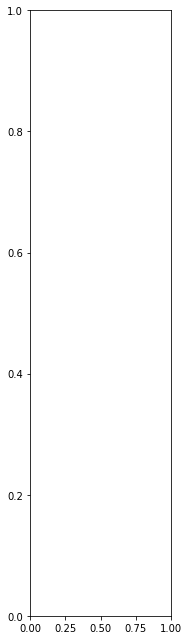

In [117]:
figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    
    
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]

    thresh = 0.5

    pred = []
    for v in y_score:
        if v > thresh:
            pred.append(1)
        else:
            pred.append(0)
    

    print(name)
    print("AUC: ", roc_auc_score(y_test, y_score))
    target_names = ['group 1', 'group 2']
    print(classification_report(y_test, pred, target_names=target_names))

plt.tight_layout()
plt.show()

# Clustering

In [76]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

In [118]:
# k-means clustering
model = KMeans(n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("k-means")
print(classification_report(Y, yhat))

k-means
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        25
           1       0.55      0.44      0.49        25

    accuracy                           0.54        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.54      0.54      0.54        50



In [119]:
# AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2)
# fit the model
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("AgglomerativeClustering")
print(classification_report(Y, yhat))

AgglomerativeClustering
              precision    recall  f1-score   support

           0       0.59      0.92      0.72        25
           1       0.82      0.36      0.50        25

    accuracy                           0.64        50
   macro avg       0.70      0.64      0.61        50
weighted avg       0.70      0.64      0.61        50



In [120]:
# GaussianMixture
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
print("GaussianMixture")
print(classification_report(Y, yhat))

GaussianMixture
              precision    recall  f1-score   support

           0       0.47      0.28      0.35        25
           1       0.49      0.68      0.57        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.46        50
weighted avg       0.48      0.48      0.46        50



In [121]:
# Birch
model = Birch(threshold=0.01, n_clusters=2)
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
print("Birch")
print(classification_report(Y, yhat))

Birch
              precision    recall  f1-score   support

           0       0.59      0.92      0.72        25
           1       0.82      0.36      0.50        25

    accuracy                           0.64        50
   macro avg       0.70      0.64      0.61        50
weighted avg       0.70      0.64      0.61        50



In [122]:
# DBSCAN
model = DBSCAN(eps=0.3, min_samples=8)
# fit model and predict clusters
yhat = model.fit_predict(X)
print("DBSCAN")
print(classification_report(Y, yhat))

DBSCAN
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00      25.0
           1       0.00      0.00      0.00      25.0

    accuracy                           0.00      50.0
   macro avg       0.00      0.00      0.00      50.0
weighted avg       0.00      0.00      0.00      50.0



c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\si

In [123]:
#MiniBatchKMeans
# define the model
model = MiniBatchKMeans(n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
print("MiniBatchKMeans")
print(classification_report(Y, yhat))

MiniBatchKMeans
              precision    recall  f1-score   support

           0       0.47      0.36      0.41        25
           1       0.48      0.60      0.54        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.47        50
weighted avg       0.48      0.48      0.47        50



## distance matrix from transition matrix

In [161]:
from scipy.spatial import distance_matrix
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [173]:
dist_matrix = distance_matrix(X, X)

In [174]:
dist_array = ssd.squareform(dist_matrix)

In [168]:
condensed_dist_matrix = ssd.squareform(dist_matrix)
condensed_dist_matrix.shape

(1225,)

In [169]:
condensed_dist_matrix

array([2.29159965, 2.08122712, 1.91137518, ..., 2.73018806, 1.94343426,
       2.41310207])

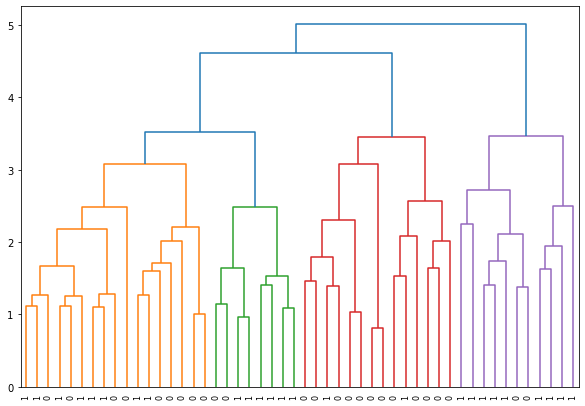

In [182]:
linked = linkage(condensed_dist_matrix, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            labels = Y,
            show_leaf_counts=True)
plt.show()

In [147]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,2.291600,2.081227,1.911375,2.284170,2.268139,2.335945,2.212888,2.015197,1.721264,...,2.070193,2.124878,1.688516,1.992818,1.749663,2.225804,1.812661,1.943377,1.998627,1.890115
1,2.291600,0.000000,1.947055,2.116297,2.689041,1.863593,2.631675,2.499642,2.016901,1.767140,...,2.207069,1.405628,2.091909,2.539756,2.509134,2.797951,2.349090,1.291323,2.859182,2.358336
2,2.081227,1.947055,0.000000,2.236211,2.821040,1.252158,2.079536,2.714119,1.822420,1.883533,...,1.982644,1.971261,1.680470,1.605916,2.548301,2.505742,1.809124,1.220456,2.620746,1.649242
3,1.911375,2.116297,2.236211,0.000000,2.740421,2.495218,2.235961,2.199267,1.851389,1.796008,...,2.509114,2.213736,2.202992,2.509517,2.324103,2.675490,2.159611,2.195325,2.359864,2.360968
4,2.284170,2.689041,2.821040,2.740421,0.000000,2.981034,2.956165,2.368075,2.954422,2.085392,...,2.358035,2.594380,2.635780,2.911451,2.363845,2.391984,3.007320,2.554869,2.955267,2.691220
5,2.268139,1.863593,1.252158,2.495218,2.981034,0.000000,2.185272,2.972317,2.297133,1.872818,...,1.855952,1.971674,1.660187,1.639639,2.677398,2.943872,1.904648,1.119299,2.687130,1.910757
6,2.335945,2.631675,2.079536,2.235961,2.956165,2.185272,0.000000,3.166967,2.335292,2.145117,...,1.884571,2.498252,2.308282,2.391770,2.949085,2.759205,1.945834,2.206211,2.661688,2.028599
7,2.212888,2.499642,2.714119,2.199267,2.368075,2.972317,3.166967,0.000000,2.767370,2.161042,...,2.821029,2.666157,2.620083,2.766946,2.009117,2.550661,2.840224,2.710467,2.746119,3.053931
8,2.015197,2.016901,1.822420,1.851389,2.954422,2.297133,2.335292,2.767370,0.000000,1.945677,...,2.497549,1.946890,2.157448,2.390229,2.684556,2.541992,2.101213,2.059478,2.249101,1.763670
9,1.721264,1.767140,1.883533,1.796008,2.085392,1.872818,2.145117,2.161042,1.945677,0.000000,...,1.805879,1.810506,1.893866,2.233525,2.012458,2.003131,2.030598,1.578166,2.117457,2.176651


In [155]:
predY

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0], dtype=int64)

In [157]:
np.array(Y)

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0])

In [158]:
predY - np.array(Y)

array([ 0, -1,  0,  1,  0, -1,  0,  0, -1,  0,  1,  1, -1, -1, -1,  0, -1,
        0,  0,  0,  0,  0, -1,  1, -1, -1,  1,  1,  0,  0,  1,  0, -1,  0,
        0,  1,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1,  1,  0],
      dtype=int64)

In [166]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
predY = cluster.fit_predict(dist_matrix)
print(classification_report(Y, predY))

              precision    recall  f1-score   support

           0       0.48      0.64      0.55        25
           1       0.47      0.32      0.38        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.47        50
weighted avg       0.48      0.48      0.47        50



c:\users\work\anaconda3\envs\kia\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
